# Sequential Model

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.convnet import *
from cs231n.solver import Solver
from cs231n.data_utils import get_CIFAR10_data
from cs231n.sequential import *
from cs231n import test
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['axes.formatter.useoffset'] = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CIFAR10

In [4]:
data = get_CIFAR10_data()

for n, d in data.items():
    if n.startswith('X'):
        d /= 127.0
    print n, d.shape

num_val = 2000
val_data = {
    'X_train': data['X_train'][:num_val],
    'y_train': data['y_train'][:num_val],
    'X_val': data['X_val'],
    'y_val': data['y_val']
}

X_val (1000, 3, 32, 32)
X_train (49000, 3, 32, 32)
X_test (1000, 3, 32, 32)
y_val (1000,)
y_train (49000,)
y_test (1000,)


## Gradcheck

**TODO**

* Fix Dense backprop
* Relu between Dense
* Gradcheck on f(x) = u.T \* g(v \* x) où g : mon réseau; u,v : random vectors

In [7]:
# Prepare a small dataset
total_examples = 3
X = data['X_train'][:total_examples, :, :8, :8]
y = data['y_train'][:total_examples]
print X.shape

(3, 3, 8, 8)


In [164]:
# Build the model
model = Sequential(batch_shape=X.shape, weight_scale=1e-3, reg=1e-1, dtype=np.float64)
model.add(Dense(num_neurons=10))
model.add(Dense(num_neurons=10))
model.add(Dense(num_neurons=10))
model.add(Dense(num_neurons=10))
model.build(loss=Softmax())
model.print_params()

Model parameters:
Dense1_Wb            (193, 10)
Dense2_Wb            (11, 10)
Dense3_Wb            (11, 10)
Dense4_Wb            (11, 10)
Total 2260


Train acc 0.666666666667   Loss 2.28065998751


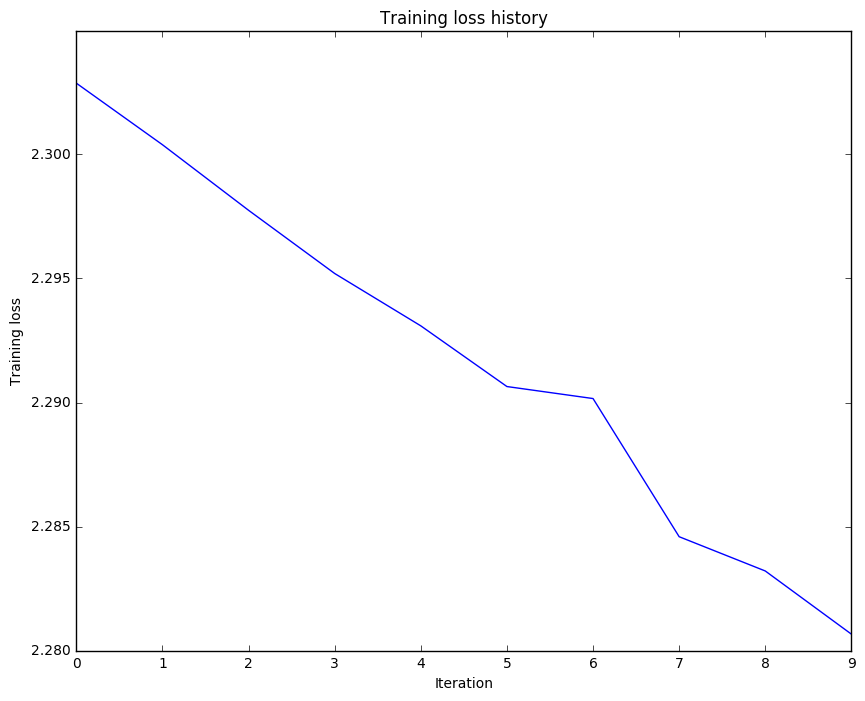

In [165]:
# Train the model a bit
solver = Solver(model, {'X_train': X, 'y_train': y, 'X_val': X, 'y_val': y},
                num_epochs=10, batch_size=X.shape[0],
                update_rule='adam',
                optim_config={
                  'learning_rate': 10**(-2.8),
                },
                verbose=False, print_every=1)
solver.train()
print 'Train acc', solver.train_acc_history[-1], '  Loss', solver.loss_history[-1]
plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [166]:
# Perform gradient check
test.gradient_check(model, X, y)


--- Gradient check ---
Max relative error:   (h = 1e-06)
Param                Error                                   Ana           Num          
Dense1_Wb            1.903942e-02  probably wrong    avgval: 8.725764e-05  8.725763e-05 
Dense2_Wb            1.075402e-04  uncomfortable     avgval: 7.956581e-05  7.956580e-05 
Dense3_Wb            1.101603e-03  uncomfortable     avgval: 2.493441e-04  2.493441e-04 
Dense4_Wb            2.818370e-05                    avgval: 1.474048e-02  1.474048e-02 


## Hyperparameter search

In [159]:
results = {}
best_solver = None
best_model = None
best_acc = -1

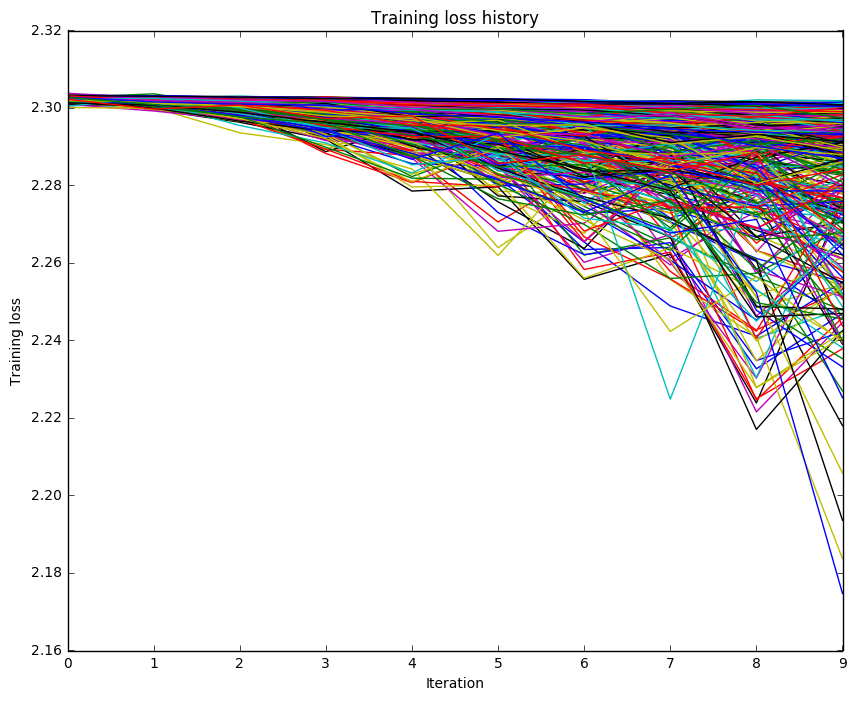

In [160]:
# Hyper parameter search

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

#batch_size = 3
#batch_shape = (batch_size,) + data['X_train'].shape[1:]

for _ in range(500):
    weight_scale = 10 ** uniform(-4, -2)
    learning_rate = 10 ** uniform(-4, -3)
    reg = 10 ** uniform(-4, -2)
    
    model = Sequential(batch_shape=X.shape, weight_scale=1e-3, reg=reg)
    model.add(Dense(num_neurons=10))
    model.add(Dense(num_neurons=10))
    model.build(loss=Softmax())
    #model = Sequential(batch_shape=batch_shape, weight_scale=weight_scale, reg=reg)
    #model.add(ConvBnRelu(8))
    #model.add(Pool())
    #model.add(ConvBnRelu(8))
    #model.add(Pool())
    #model.add(Dense(num_neurons=10))
    #model.build(loss=Softmax())
    
    solver = Solver(model, {'X_train': X, 'y_train': y, 'X_val': X, 'y_val': y},
                num_epochs=10, batch_size=X.shape[0],
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                },
                verbose=False, print_every=1)
    #solver = Solver(model, val_data,
    #                print_every=10, num_epochs=5, batch_size=batch_size,
    #                update_rule='adam',
    #                optim_config={
    #                  'learning_rate': learning_rate,
    #                },
    #                verbose=True)
    solver.train()
    #acc = solver.val_acc_history[-1]
    acc = solver.train_acc_history[-1]
    final_loss = solver.loss_history[-1]
    format_str = '{:e} {:e}  final l: {:.5f}  acc: {}'
    #print format_str.format(reg, learning_rate, final_loss, acc)
    if np.max(solver.loss_history) > 10:
        continue
    plt.plot(solver.loss_history, '-')
    results[(reg, learning_rate, weight_scale)] = (acc, final_loss)
    if acc > best_acc:
        best_acc = acc
        best_solver = solver
        best_model = model

plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

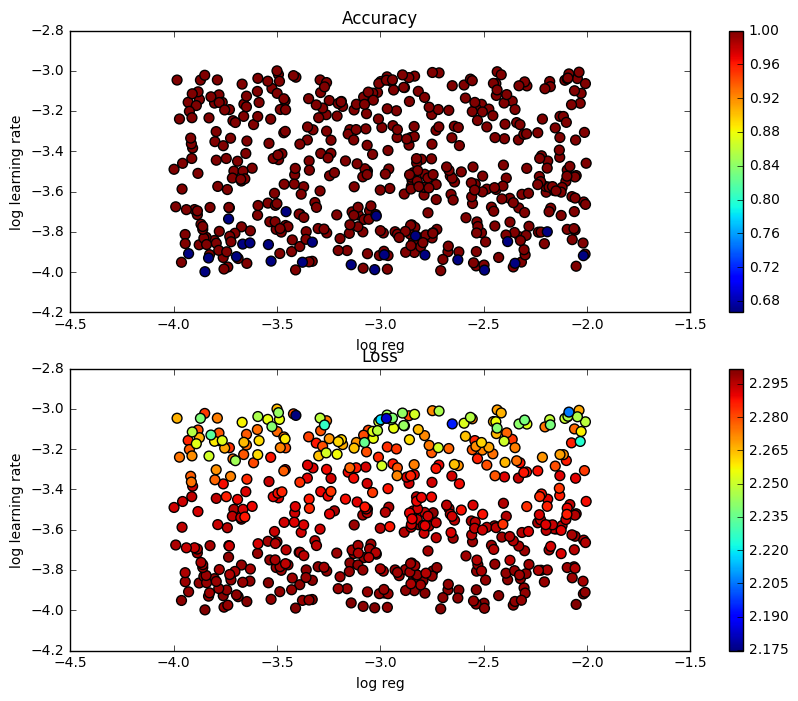

In [163]:
# Visualize the cross-validation results
import math
marker_size = 50
x_scatter, x_label = np.array([np.log10(x[0]) for x in results]), 'log reg'
#x_scatter, x_label = np.array([np.log10(x[2]) for x in results]), 'log weight scale'
y_scatter, y_label = np.array([np.log10(x[1]) for x in results]), 'log learning rate'

# plot validation accuracy
things = [(0, 'Accuracy', -1),
          (1, 'Loss', -1)]
for i, th in enumerate(things):
    color_data_i, title, sens = th
    colors = np.array([results[x][color_data_i] for x in results])
    plt.subplot(2, 1, i+1)
    order = np.argsort(colors)[::sens]
    plt.scatter(x_scatter[order], y_scatter[order], marker_size, c=colors[order])
    plt.colorbar()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
plt.show()

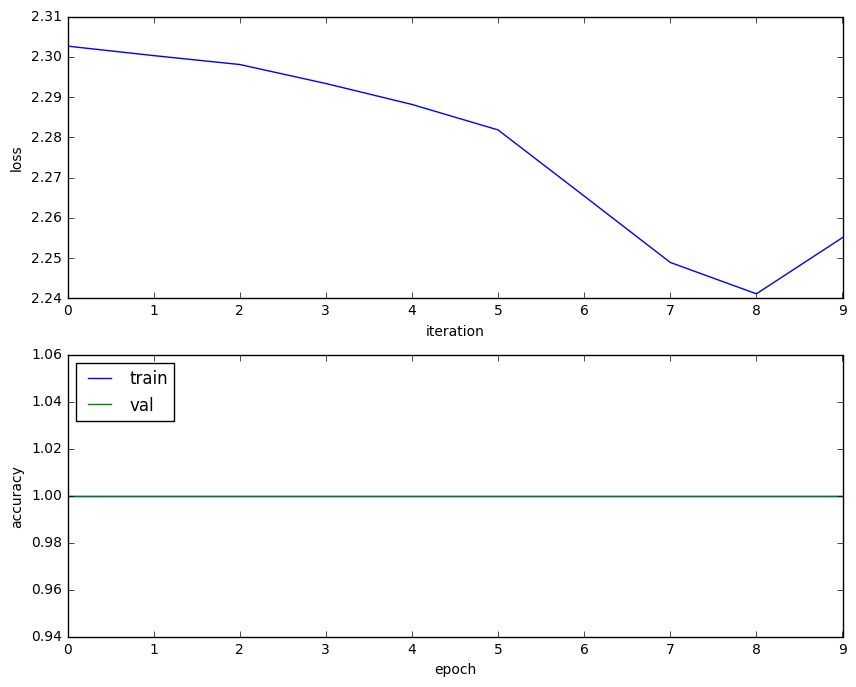

In [162]:
plt.subplot(2, 1, 1)
plt.plot(best_solver.loss_history, '-')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(best_solver.train_acc_history, '-')
plt.plot(best_solver.val_acc_history, '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

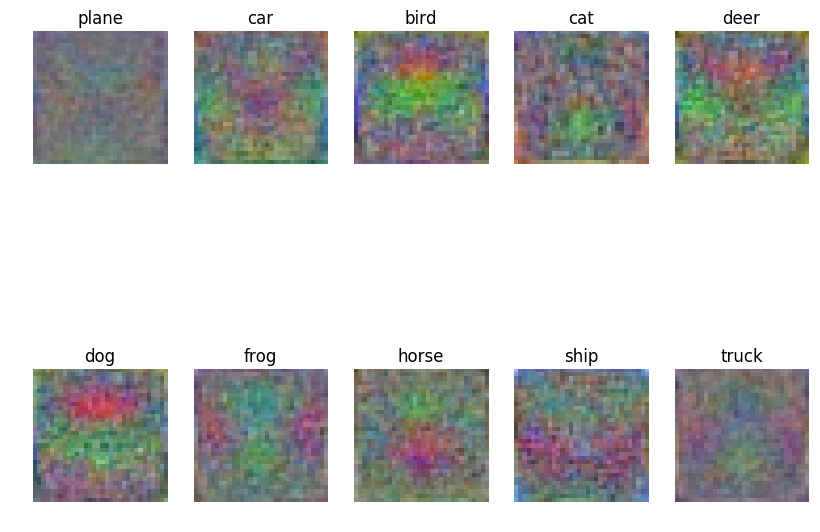

In [165]:
# Visualize the learned weights for each class
w = best_model.params['Dense1_Wb'][:-1,:10] # strip out the bias
w = w.reshape(3, 32, 32, -1)
w = np.moveaxis(w, 0, 2)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])